In [1]:
## Random Forest

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import connectorx as cx
import math
import time
import shap
import pickle
import seaborn as sns
import os
import pandas as pd
from sqlalchemy import create_engine
import urllib.parse
import mlflow
from mlflow.models import infer_signature
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score, explained_variance_score, mean_absolute_error
from sklearn.ensemble import RandomForestRegressor
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import cross_val_score, train_test_split
import statistics
import xgboost as xgb
import plotly.express as px
from sklearn.preprocessing import MultiLabelBinarizer

## Data Preparation

In [5]:
pd.set_option('display.max_columns',None)

In [2]:
database = 'isgpostgres'
user = 'postgres'
password = '123@NjMpTs'
host = '20.62.75.39'
port = '9030'
encoded_password = urllib.parse.quote(password)
connection_string = "postgresql+psycopg2://" + user + ":" + encoded_password + "@" + host + ":" + port + "/" + database
engine = create_engine(connection_string)

sql_command = """ select isg_osm_id,highway_id,region,roadwaytype_id,
cur_lanes_cat,cur_spd_cat,
case 
when cur_final_place = 'town' then 0 
when cur_final_place = 'locality' then 1  
when cur_final_place = 'city' then 2  
when cur_final_place = 'village' then 3  
when cur_final_place = 'hamlet' then 4 
when cur_final_place = 'neighbourhood' then 5 
when cur_final_place = 'unknown' then 6
else 7
end as cur_final_place,
case when cur_areatype = 'Rural' then 0 else 1  end as cur_areatype,
cur_final_place as cur_final_place_str,
cur_areatype as cur_areatype_str,
cur_cap_cat,prev_connected_count,volume,
prev_isg_osm_id_arr,prev_highway_id_arr,
prev_region_arr,prev_roadwaytype_id_arr,
prev_lanes_cat_arr,prev_spd_cat_arr,prev_cap_cat_arr,
prev_cur_final_place_arr as prev_final_place_arr,prev_cur_areatype_arr as prev_areatype_arr,
prev_ncc_arr,prev_volume,prev_ncc_arr[1] as extract from tm_new_data.prev_cur_model_data_240611 where volume>0 and prev_volume > 0  """

# Execute the query and fetch the data
data = pd.read_sql_query(sql_command, engine)

In [3]:
seen_df = data.copy()
seen_df.shape,seen_df.columns

((37301, 25),
 Index(['isg_osm_id', 'highway_id', 'region', 'roadwaytype_id', 'cur_lanes_cat',
        'cur_spd_cat', 'cur_final_place', 'cur_areatype', 'cur_final_place_str',
        'cur_areatype_str', 'cur_cap_cat', 'prev_connected_count', 'volume',
        'prev_isg_osm_id_arr', 'prev_highway_id_arr', 'prev_region_arr',
        'prev_roadwaytype_id_arr', 'prev_lanes_cat_arr', 'prev_spd_cat_arr',
        'prev_cap_cat_arr', 'prev_final_place_arr', 'prev_areatype_arr',
        'prev_ncc_arr', 'prev_volume', 'extract'],
       dtype='object'))

In [6]:
seen_df

,isg_osm_id,highway_id,region,roadwaytype_id,cur_lanes_cat,cur_spd_cat,cur_final_place,cur_areatype,cur_final_place_str,cur_areatype_str,cur_cap_cat,prev_connected_count,volume,prev_isg_osm_id_arr,prev_highway_id_arr,prev_region_arr,prev_roadwaytype_id_arr,prev_lanes_cat_arr,prev_spd_cat_arr,prev_cap_cat_arr,prev_final_place_arr,prev_areatype_arr,prev_ncc_arr,prev_volume,extract
0,4350449001,2,5,16,2,1,1,1,locality,Urban,2,1,1720,[139470173003],[1],[5],[10],[2],[3],[2],[locality],[Urban],[2],2948,2
1,4350451001,1,5,10,2,3,1,1,locality,Urban,3,2,2579,"[24137110001, 94449377001]","[2, 2]","[5, 5]","[16, 16]","[2, 2]","[1, 2]","[2, 2]","[locality, locality]","[Urban, Urban]","[1, 1]",2579,1
2,4350451002,1,5,10,2,3,1,1,locality,Urban,3,1,2877,[4350451001],[1],[5],[10],[2],[3],[3],[locality],[Urban],[1],2579,1
3,4350451003,1,5,10,2,3,1,1,locality,Urban,3,1,2877,[4350451002],[1],[5],[10],[2],[3],[3],[locality],[Urban],[1],2877,1
4,4371845002,1,5,10,2,3,0,1,town,Urban,2,2,1139,"[4371845001, 5715198002]","[1, 2]","[5, 5]","[10, 16]","[1, 2]","[2, 3]","[1, 2]","[city, city]","[Urban, Urban]","[1, 1]",1139,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
37296,9991047524098012,5,5,1,1,2,1,1,locality,Urban,0,1,347,[9991047524098013],[5],[5],[1],[1],[2],[0],[locality],[Urban],[1],347,1
37297,9991051856154001,5,1,1,1,2,0,1,town,Urban,0,1,863,[9991051856154002],[5],[1],[1],[1],[2],[0],[town],[Urban],[1],863,1
37298,9991051856154002,5,1,1,1,2,0,1,town,Urban,0,1,863,[99935832913001],[5],[1],[1],[1],[2],[0],[town],[Urban],[1],863,1
37299,9991052176794003,5,9,1,1,2,0,0,town,Rural,0,1,73,[9991052176795001],[5],[9],[3],[1],[2],[0],[town],[Rural],[1],73,1


In [9]:
encoded_feature_lst = ['prev_highway_id_arr', 'prev_region_arr',
                           'prev_roadwaytype_id_arr', 'prev_ncc_arr',
                           'prev_lanes_cat_arr', 'prev_spd_cat_arr',
                           'prev_cap_cat_arr', 'prev_final_place_arr',
                           'prev_areatype_arr']

unencoded_feature_lst =  ['highway_id', 'region', 'roadwaytype_id',
                          'cur_lanes_cat','cur_spd_cat','cur_cap_cat','prev_connected_count',
                          'cur_final_place','cur_areatype',
                          'prev_volume']

target_feature_lst= ['volume']

In [10]:
features_unencoded_df = seen_df[unencoded_feature_lst].reset_index(drop=True)

features_unencoded_df.shape

(37301, 10)

In [11]:
features_unencoded_df

,highway_id,region,roadwaytype_id,cur_lanes_cat,cur_spd_cat,cur_cap_cat,prev_connected_count,cur_final_place,cur_areatype,prev_volume
0,2,5,16,2,1,2,1,1,1,2948
1,1,5,10,2,3,3,2,1,1,2579
2,1,5,10,2,3,3,1,1,1,2579
3,1,5,10,2,3,3,1,1,1,2877
4,1,5,10,2,3,2,2,0,1,1139
...,...,...,...,...,...,...,...,...,...,...
37296,5,5,1,1,2,0,1,1,1,347
37297,5,1,1,1,2,0,1,0,1,863
37298,5,1,1,1,2,0,1,0,1,863
37299,5,9,1,1,2,0,1,0,0,73


In [12]:
mlb = MultiLabelBinarizer()
encoded_obj_dict = {}
features_encoded_df = pd.DataFrame()
for col in encoded_feature_lst:
    #one_hot_encoded = mlb.fit_transform(seen_df[col])
    mlb.fit(seen_df[col])  # Fit the encoder
    
    seen_one_hot_encoded = mlb.transform(seen_df[col]) 
    seen_temp_df = pd.DataFrame(seen_one_hot_encoded, columns=[f'{col}_{i}' for i in range(1, seen_one_hot_encoded.shape[1] + 1)])
    features_encoded_df = pd.concat([features_encoded_df,seen_temp_df],axis=1)    
    encoded_obj_dict[col] = mlb

features_encoded_df.shape

(37301, 59)

In [13]:
features_encoded_df

,prev_highway_id_arr_1,prev_highway_id_arr_2,prev_highway_id_arr_3,prev_highway_id_arr_4,prev_highway_id_arr_5,prev_highway_id_arr_6,prev_region_arr_1,prev_region_arr_2,prev_region_arr_3,prev_region_arr_4,prev_region_arr_5,prev_region_arr_6,prev_region_arr_7,prev_region_arr_8,prev_region_arr_9,prev_region_arr_10,prev_region_arr_11,prev_roadwaytype_id_arr_1,prev_roadwaytype_id_arr_2,prev_roadwaytype_id_arr_3,prev_roadwaytype_id_arr_4,prev_roadwaytype_id_arr_5,prev_roadwaytype_id_arr_6,prev_roadwaytype_id_arr_7,prev_roadwaytype_id_arr_8,prev_roadwaytype_id_arr_9,prev_roadwaytype_id_arr_10,prev_roadwaytype_id_arr_11,prev_roadwaytype_id_arr_12,prev_roadwaytype_id_arr_13,prev_roadwaytype_id_arr_14,prev_roadwaytype_id_arr_15,prev_roadwaytype_id_arr_16,prev_roadwaytype_id_arr_17,prev_roadwaytype_id_arr_18,prev_roadwaytype_id_arr_19,prev_ncc_arr_1,prev_ncc_arr_2,prev_ncc_arr_3,prev_ncc_arr_4,prev_ncc_arr_5,prev_lanes_cat_arr_1,prev_lanes_cat_arr_2,prev_spd_cat_arr_1,prev_spd_cat_arr_2,prev_spd_cat_arr_3,prev_cap_cat_arr_1,prev_cap_cat_arr_2,prev_cap_cat_arr_3,prev_cap_cat_arr_4,prev_final_place_arr_1,prev_final_place_arr_2,prev_final_place_arr_3,prev_final_place_arr_4,prev_final_place_arr_5,prev_final_place_arr_6,prev_final_place_arr_7,prev_areatype_arr_1,prev_areatype_arr_2
0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,1,0,0,1,0,0,1,0,0,0,1,0,0,0,0,0,1
1,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,1,1,1,0,0,0,1,0,0,0,1,0,0,0,0,0,1
2,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,1,0,0,0,1,0,0,1,0,0,0,0,0,1
3,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,1,0,0,0,1,0,0,1,0,0,0,0,0,1
4,1,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,1,1,0,1,1,0,1,1,0,1,0,0,0,0,0,0,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
37296,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,1,0,0,1,0,1,0,0,0,0,0,1,0,0,0,0,0,1
37297,0,0,0,0,1,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,1,0,0,1,0,1,0,0,0,0,0,0,0,1,0,0,0,1
37298,0,0,0,0,1,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,1,0,0,1,0,1,0,0,0,0,0,0,0,1,0,0,0,1
37299,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,1,0,0,1,0,1,0,0,0,0,0,0,0,1,0,0,1,0


In [15]:
with open('encoders.pkl','wb') as f:
    pickle.dump(encoded_obj_dict, f)

In [16]:
final_seen_df = pd.concat([features_unencoded_df,features_encoded_df],axis=1)
final_seen_df['volume'] = list(map(lambda x : x ,seen_df['volume']))
final_seen_df.shape

(37301, 70)

## Train Test Split

In [10]:
X,y = final_seen_df.iloc[:,0:-1],final_seen_df[target_feature_lst]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
X_train.shape,X_test.shape, y_train.shape, y_test.shape

((29840, 69), (7461, 69), (29840, 1), (7461, 1))

In [11]:
def geh_check(row):
    current_vol = row['volume']
    next_vol = row['predicted_volume']
    metric_value = float(np.sqrt(2 * np.sum((current_vol - next_vol) ** 2) / np.sum(current_vol + next_vol)))
    return metric_value

In [12]:
def get_geh(y_test, y_pred):
    geh_lst = []
    for i,j in zip(y_test, y_pred):
        row = {'volume':i,'predicted_volume':j}
        geh_lst.append(geh_check(row))
    mean_geh = round(statistics.mean(geh_lst),3)
    return mean_geh,geh_lst

In [13]:
os.environ['MLFLOW_TRACKING_USERNAME'] = 'isgadmin'
os.environ['MLFLOW_TRACKING_PASSWORD'] = 'infosense12@'
tracking_server_uri = "https://ptt2-mlflow.isgsuite.com/"
mlflow.set_tracking_uri(tracking_server_uri)
tracking_uri = mlflow.get_tracking_uri()
print("Tracking URI:", tracking_uri)

Tracking URI: https://ptt2-mlflow.isgsuite.com/


In [14]:
# experiment_name = "TM_New_Approach"
# experiment = mlflow.set_experiment(experiment_name)
# experiment_id = experiment.experiment_id
run_name = 'RF_FC_1_2_3_Delete_Run'
description = 'previous as input values and current is target'
# Get Experiment Details
# print(f"Experiment_id: {experiment.experiment_id}")
print(f"Run Name: {run_name}")
print(f"Description: {description}")
# print(f"Artifact Location: {experiment.artifact_location}")

Run Name: RF_FC_1_2_3_Delete_Run
Description: previous as input values and current is target


In [15]:
def get_test_dataset(X_test,y_test,y_pred):
    Test_Data_Df = X_test.copy()
    Test_Data_Df['volume'] = y_test['volume']
    Test_Data_Df['predicted_volume']=y_pred
    Test_Data_Df['predicted_volume']=Test_Data_Df['predicted_volume'].round().astype(int)
    Test_Data_Df['diff']=Test_Data_Df['volume']-Test_Data_Df['predicted_volume']
    Test_Data_Df['geh'] = Test_Data_Df.apply(lambda row: geh_check(row), axis=1)
    Test_Data_Df['geh'] = Test_Data_Df['geh'].round(3)
    return Test_Data_Df

def get_regressor_metrices(y_test,y_pred,rows,cols,geh_threshold):
    mse = round(mean_squared_error(y_test, y_pred),3)
    rmse = round(np.sqrt(mse),3)
    r2 = round(r2_score(y_test, y_pred),3)

    adjusted_r2score =  round((1 - (1 - r2) * (rows - 1) / (rows - cols - 1)),3)
    mae = round(mean_absolute_error(y_test, y_pred),3)
    
    m_geh,geh_lst = get_geh(y_test.values, y_pred)
    geh_error_counts = len(list(filter(lambda x : x>geh_threshold,geh_lst)))
    geh_error_per = round(((geh_error_counts/rows)*100),3)
    
    metrices = {'mse':mse,'rmse':rmse,'r2score':r2,'mae':mae,'adjusted_r2score' : adjusted_r2score,
               'mean_geh':m_geh,'test_data_size':rows,'geh_error_counts':geh_error_counts,'geh_error_percentage':geh_error_per}
    return metrices

def get_feature_importance(xg_reg,X_train):
    explainer = shap.TreeExplainer(xg_reg)
    shap_values = explainer.shap_values(X_train[:500])
    fig = shap.summary_plot(shap_values, X_train[:500], plot_type="bar",show=False)
    return fig

def get_actual_vs_prediction(Test_Data_Df):  
    fig = px.scatter(Test_Data_Df, x='volume', y='predicted_volume')
    fig.add_trace(px.line(Test_Data_Df, x='volume', y='volume').data[0])
    fig.update_layout(xaxis_title='Actual Values', yaxis_title='Predicted Values')
    html_str = fig.to_html(full_html=False)
    return html_str
    with open("Actual_Vs_Prediction_Plot.html", "w") as f:
        f.write(html_str)
    mlflow.log_artifact("Actual_Vs_Prediction_Plot.html", "html")

In [16]:
def log_model_summary(model_log_params):
    try:
        model_data = model_log_params['model_data']
        xg_reg = model_data['model_object']
        X_train = model_data['X_train'] 
        X_test = model_data['X_test']
        y_train = model_data['y_train'] 
        y_test = model_data['y_test'] 
        y_pred = model_data['y_pred']
        geh_threshold = model_log_params['geh_threshold']
        rows = model_log_params['test_size']
        cols = model_log_params['no_of_input_features']

        # Log Parameter
        xgb_params = xg_reg.get_params()
        mlflow.log_params(xgb_params)
        
        # Log Metrics
        metrices = get_regressor_metrices(y_test,y_pred,rows,cols,geh_threshold)
        mlflow.log_metrics(metrices)
        model_log_params.pop('model_data')
        # Log tags
        mlflow.set_tags(model_log_params)
    
        # Log Feature Importance
        fig = get_feature_importance(xg_reg,X_train)
        image_path = "Feature_Importance.png"    
        plt.savefig(image_path)
        mlflow.log_artifact(image_path, "images")
    
        # Log test datatset
        Test_Data_Df = get_test_dataset(X_test,y_test,y_pred)
        dataset = mlflow.data.from_pandas(Test_Data_Df, targets="volume", predictions="predicted_volume", name ='test_dataset')
        mlflow.log_input(dataset, context="test")
        
        # Log Actual Vs Prediction Plot
        html_str = get_actual_vs_prediction(Test_Data_Df)
        with open("Actual_Vs_Prediction_Plot.html", "w") as f:
            f.write(html_str)
        mlflow.log_artifact("Actual_Vs_Prediction_Plot.html", "html")
    
    
        # Log Model
        signature = infer_signature(X_test, y_pred)
        mlflow.sklearn.log_model(xg_reg, "model", signature=signature)
        return 0
    except Exception as e:
        return e

2024/06/17 15:03:05 WARNING mlflow.utils.git_utils: Failed to import Git (the Git executable is probably not on your PATH), so Git SHA is not available. Error: Failed to initialize: Bad git executable.
The git executable must be specified in one of the following ways:
    - be included in your $PATH
    - be set via $GIT_PYTHON_GIT_EXECUTABLE
    - explicitly set via git.refresh()

All git commands will error until this is rectified.

This initial warning can be silenced or aggravated in the future by setting the
$GIT_PYTHON_REFRESH environment variable. Use one of the following values:
    - quiet|q|silence|s|none|n|0: for no warning or exception
    - warn|w|warning|1: for a printed warning
    - error|e|raise|r|2: for a raised exception

Example:
    export GIT_PYTHON_REFRESH=quiet

C:\Users\AshishPrajapati\AppData\Local\Temp\ipykernel_13928\186502257.py:18: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,)

0


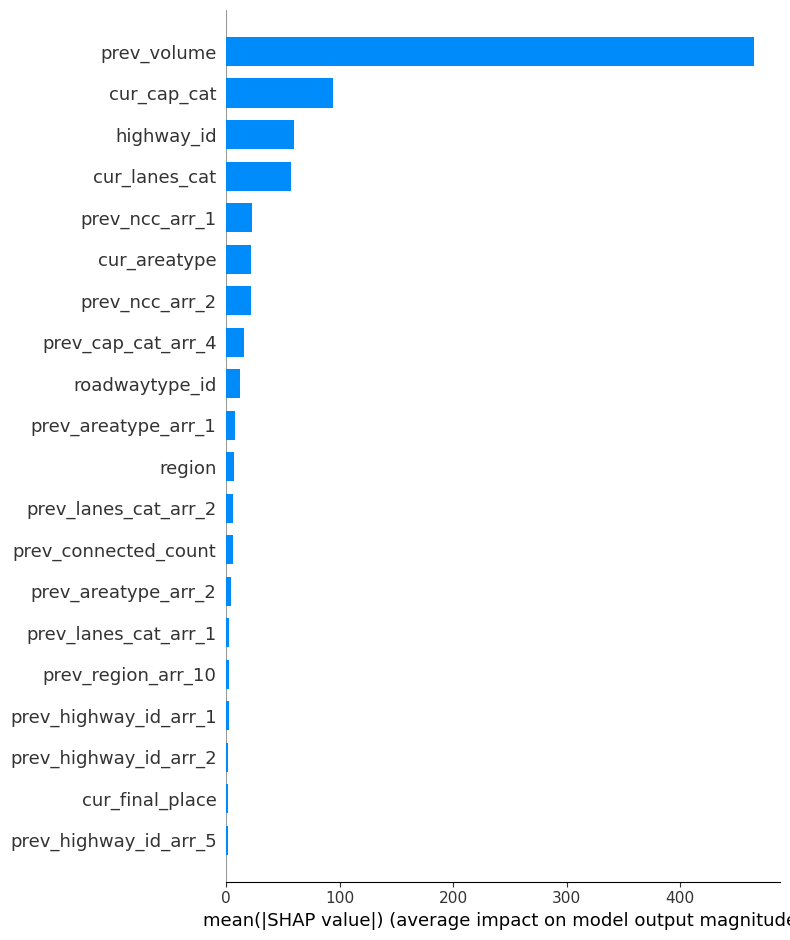

In [17]:
with mlflow.start_run(experiment_id="59",run_name = run_name,description=description) as run:

    # Define the XGBoost regressor with the specified parameters
    params = {
    'n_estimators' : 500,
    'max_depth' : 8,
    'max_leaf_nodes' : 2000,
    'min_samples_split' : 2,
    'min_samples_leaf' : 15,
    'bootstrap' : False,
    'random_state' : 1234,
    'criterion' : 'poisson',
    'max_features' : 0.6
    }
    
    # Train the model
    xg_reg = RandomForestRegressor(**params)
    xg_reg.fit(X_train, y_train)
    # Make predictions on the test set
    y_pred = xg_reg.predict(X_test)
    y_test['volume'] = round(y_test['volume'],0).astype(int)
    y_pred = np.rint(y_pred).astype(int)

    model_data = {
        'model_object' : xg_reg,
        'X_train' : X_train, 'X_test' : X_test,
        'y_train' : y_train , 'y_test' : y_test, 'y_pred' : y_pred,
        'model_params' : params   
    }
    
    model_log_params ={
        'geh_threshold' : 5,
        'test_size':X_test.shape[0], 'no_of_input_features':X_test.shape[1],
        'input_feature_lst':X_train.columns.tolist(),
        'target_feature_lst': target_feature_lst,
        'Model_Name' : 'Random Forest',
        'Train Size' : X_train.shape[0],
        'model_data' : model_data
    }

        
    # Log Model Summary
    output = log_model_summary(model_log_params)
    print(output)
    mlflow.end_run()  

### Prepare Data For unseen data

In [18]:
# unseen_df_1 = final_unseen_df.copy()
# unseen_df_1['volume'] = list(map(lambda x : x ,unseen_df['volume']))

In [19]:
# unseen_pred = xg_reg.predict(final_unseen_df[X_test.columns.tolist()])

# unseen_df_1['predicted_volume'] = unseen_pred
# unseen_df_1['predicted_volume'] = unseen_df_1['predicted_volume'].round().astype(int)

In [20]:
# def geh_check_unseen(row):
#     current_vol = row['prev_volume']
#     next_vol = row['predicted_volume']
#     metric_value = float(np.sqrt(2 * np.sum((current_vol - next_vol) ** 2) / np.sum(current_vol + next_vol)))
#     return metric_value

In [21]:
# unseen_df_1['GEH'] = unseen_df_1.apply(geh_check_unseen, axis=1)
# unseen_df_1.shape

In [22]:
# unseen_df_1[unseen_df_1['GEH'] > 25 ].shape